In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM

from scipy.stats import probplot
from scipy.stats import normaltest

from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [4]:
enc = OrdinalEncoder()
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

X_train_healthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]

X_valid_healthy = X_valid[np.argwhere(Y_valid.flatten()==1).flatten(),:]
Y_valid_healthy = Y_valid[np.argwhere(Y_valid.flatten()==1).flatten()]
X_valid_unhealthy = X_valid[np.argwhere(Y_valid.flatten()==0).flatten(),:]
Y_valid_unhealthy = Y_valid[np.argwhere(Y_valid.flatten()==0).flatten()]
np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)

X = np.dstack((X_train_healthy,X_valid_healthy,X_train_unhealthy,X_valid_unhealthy))

num_samples = np.array([X_train_healthy.shape[0],
          X_valid_healthy.shape[0],
          X_train_unhealthy.shape[0],
          X_valid_unhealthy.shape[0]])

columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

max_samples = np.amax(num_samples)

In [5]:
np.savetxt('data/X_train_healthy.csv',X[...,0],delimiter=',')
np.savetxt('data/X_valid_healthy.csv',X[...,1],delimiter=',')
np.savetxt('data/X_train_unhealthy.csv',X[...,2],delimiter=',')
np.savetxt('data/X_valid_unhealthy.csv',X[...,3],delimiter=',')

In [6]:
"2020-04-15T22:08:50.502Z"

'2020-04-15T22:08:50.502Z'

In [7]:
pca = PCA(n_components=64)
X_condensed_pca = pca.fit_transform(X[...,0])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

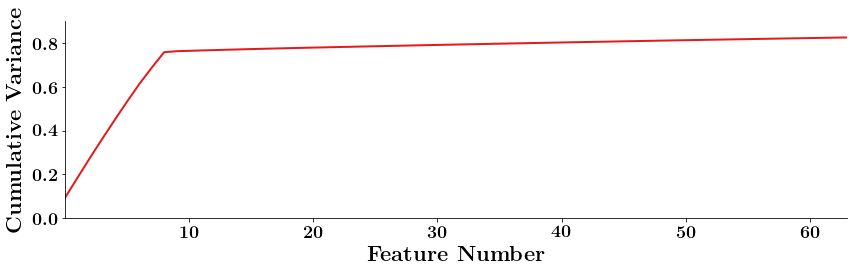

In [8]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((cumulative_variance))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(np.arange(cumulative_variance.shape[0]), # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Feature Number',# X - axis label
              r'Cumulative Variance',   # Y - axis label
              filename='Test_PCA_Decomposition',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )



In [9]:
estimators = [('reduce_dim', PCA(n_components=64)), ('gmm', GaussianMixture())]
# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train_healthy)

scores_gmm = np.zeros((max_samples,4))

for i in range(len(columns)):
    scores_gmm[:,i] = pipe.score_samples(X[...,i])

In [10]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

NormaltestResult(statistic=1.3169754535242717, pvalue=0.5176335462426793)
NormaltestResult(statistic=71.70320216389213, pvalue=2.6905897458452537e-16)
NormaltestResult(statistic=16.78938338777595, pvalue=0.00022606416255202124)
NormaltestResult(statistic=42.395731364416406, pvalue=6.221339565129312e-10)
1.0 1.2269550455000302e-15
3.7815160842307183 2.848417798237867
2.158351980605032 -0.3404324522466839
3.197671831672644 4.526399321074137


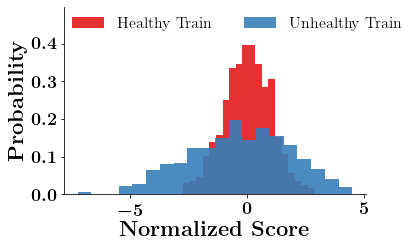

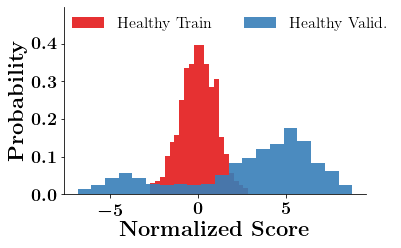

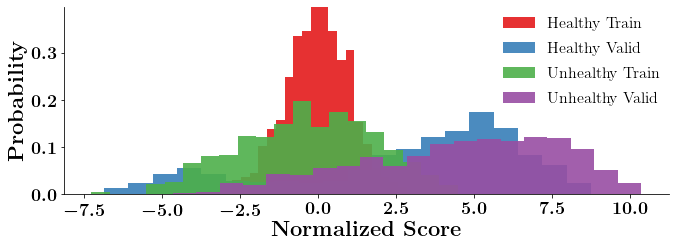

In [11]:
norm_scores_gmm = normalize_scores(scores_gmm,log_prob=True)

responses = np.vstack((norm_scores_gmm[:,0],
                       norm_scores_gmm[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.1,
               num_col=2)

responses = np.vstack((norm_scores_gmm[:,0],
                       norm_scores_gmm[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper left',
               ymax=0.1,
               num_col=2)

genplt.plot_histogram(norm_scores_gmm,columns,
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_All',
               template='wide',
               ymax=0.0,
               num_col=1)


In [12]:
print(pipe['gmm'].covariances_.size)
print(pipe['gmm'].weights_.size)
print(pipe['gmm'].means_.size)

dump(pipe, 'data/pca_gmm.joblib') 

4096
1
64


['data/pca_gmm.joblib']

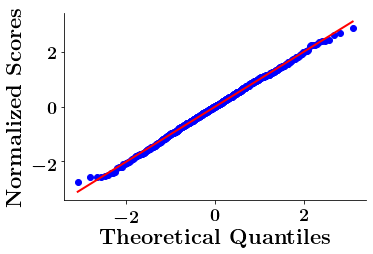

No handles with labels found to put in legend.


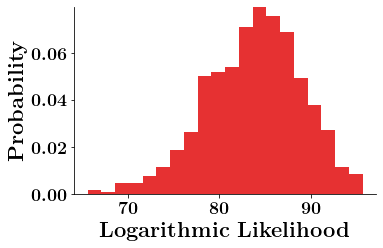

In [13]:
genplt.plot_normaltest(norm_scores_gmm[...,0],
                'Theoretical Quantiles',
                'Normalized Scores',
                'PCA-GMM_NormalTest')

genplt.plot_histogram(scores_gmm[...,0],[''],
               'Logarithmic Likelihood',
               'Probability',
               'PCA-GMM_Histogram_Train_Healthy',
               template='publication')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64)                557632    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1024)              558592    
Total params: 1,116,224
Trainable params: 1,116,224
Non-trainable params: 0
_________________________________________________________________
None
NormaltestResult(statistic=14.764678856542856, pvalue=0.0006221437215870405)
NormaltestResult(statistic=151.98671864470737, pvalue=9.919810709825156e-34)
NormaltestResult(statistic=245.79855372251444, pvalue=4.222038889000505e-54)
NormaltestResult(statistic=308.4233238867481, pvalue=1.0634722765848147e-67)
0.9999999999999999 -1.0785023667787234e-15
23.808694342290213 42.58739012390988
8.236164485419442 16.52098306237834
26.938479384867296 59.695143089396964
Model: "sequential_2"
_________________

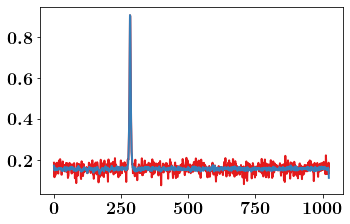

In [14]:
if os.path.isfile('data/AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/AE.h5')
    print(model.summary())
else:
    param_dict = {
        "hidden_nodes":[512,64],
        "input_shape":[1024],
    }
    max_epochs = 20
    batch_size = 16
    verbose = 0

    model,encoder,decoder = create_vanilla_ae(param_dict)

    model.compile(loss='mean_squared_error', 
                  optimizer='adam')

    loss = model.fit(
                X[...,0],X[...,0],
                validation_split=0.2,
                epochs=max_epochs,
                batch_size=batch_size,
                verbose=verbose)
    
    
    model.save('data/AE.h5',save_format='tf')

X_vanilla_ae = np.zeros_like(X)
mse_vanilla_ae = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_vanilla_ae[...,i] = model.predict(X[...,i])
    mse_vanilla_ae[:,i] = keras.metrics.mean_squared_error(X_vanilla_ae[...,i],X[...,i])

norm_vanilla_ae = normalize_scores(mse_vanilla_ae)

print(model.summary())

plt.plot(X[0,:,0])
plt.plot(X_vanilla_ae[0,:,0])
plt.show()

In [15]:
np.atleast_2d(X[0,:,0]).shape

(1, 1024)

In [16]:
model.predict(np.atleast_2d(X[0,:,0]))

array([[0.17325172, 0.15609005, 0.15002808, ..., 0.16390614, 0.15582083,
        0.11403547]], dtype=float32)

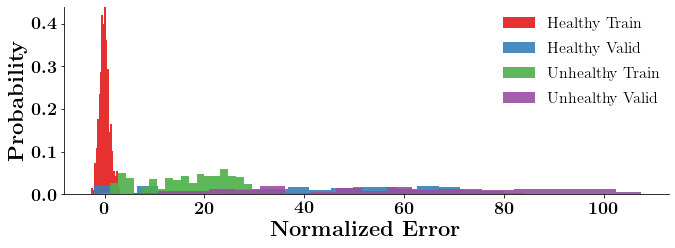

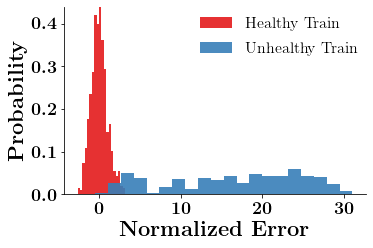

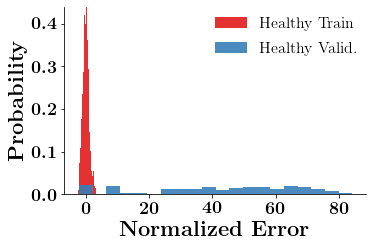

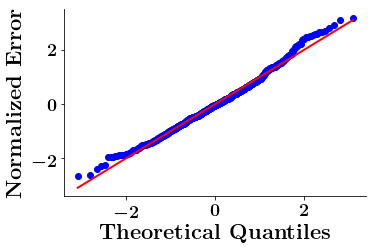

No handles with labels found to put in legend.


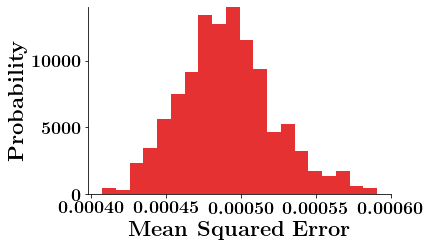

In [17]:
genplt.plot_histogram(norm_vanilla_ae,columns,
               'Normalized Error',
               'Probability',
               'AE_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_vanilla_ae[:,0],
                       norm_vanilla_ae[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_vanilla_ae[:,0],
                       norm_vanilla_ae[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'AE_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_vanilla_ae[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'AE_NormalTest')

genplt.plot_histogram(mse_vanilla_ae[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'AE_Histogram_Train_Healthy',
               template='publication')

In [18]:
import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_encoder(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape
                   ):
    
    encoder = Sequential()
    
    for i in range(len(filters)):
        if i == 0:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i],
                               input_shape=input_shape))
        else:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(0.5))
        encoder.add(MaxPooling1D(2))
        
    return encoder

def create_decoder(
                   filters,
                   kernels,
                   strides,
                   dilation_rates,
                   ):
    
    decoder = Sequential()
    
    filters.reverse()
    kernels.reverse()
    strides.reverse()
    dilation_rates.reverse()
    
    decoder.add(UpSampling1D(2))
    
    for i in range(1,len(filters)):
        decoder.add(Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i]))
#         decoder.add(Dropout(0.5))
        decoder.add(UpSampling1D(2))
    
    #decoder.add(Dropout_Live(0.5))
    decoder.add(Conv1D(1, 3, 1, activation='sigmoid', padding='same'))
    
    return decoder
    
def create_autoencoder(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
        
    encoder = create_encoder(filters,kernels,strides,dilation_rates,input_shape)
    decoder = create_decoder(filters,kernels,strides,dilation_rates)
    
    stacked_ae = Sequential([encoder, decoder])

    return stacked_ae,encoder,decoder
    

In [19]:
if os.path.isfile('data/CNN-AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-AE.h5')
    print(model.summary())
else:
    filters=[8,16,32]
    kernels = [3,3,3]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [1024,1]

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
    }

    model,encoder,decoder = create_autoencoder(param_dict)

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X[...,0,np.newaxis],X[...,0,np.newaxis],
                        epochs=30,batch_size=16,
                        validation_split=0.2,verbose=1,
    #                     validation_data=[X_healthy_test[...,np.newaxis],X_healthy_test[...,np.newaxis]]
                       )
    
    model.save('data/CNN-AE.h5',save_format='tf')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(os.path.join('data', 'CNN-AE.tflite',),
     "wb").write(tflite_model)

X_conv_ae = np.zeros_like(X)
mse_conv_ae = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_conv_ae[...,i] = np.squeeze(model.predict(X[...,i,np.newaxis]))
    mse_conv_ae[:,i] = keras.metrics.mean_squared_error(X_conv_ae[...,i],X[...,i])

norm_conv_ae = normalize_scores(mse_conv_ae)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 128, 32)           2224      
_________________________________________________________________
sequential_19 (Sequential)   (None, 1024, 1)           1969      
Total params: 4,193
Trainable params: 4,081
Non-trainable params: 112
_________________________________________________________________
None
NormaltestResult(statistic=5.878765631372799, pvalue=0.05289836670764005)
NormaltestResult(statistic=149.16742612921692, pvalue=4.06167318883934e-33)
NormaltestResult(statistic=120.031256463999, pvalue=8.620725784247805e-27)
NormaltestResult(statistic=35.68624181188337, pvalue=1.7816855207226002e-08)
1.0 -1.0594699720708637e-15
1.7063636998525387 0.47940417146779085
1.7312699375591365 7.922279361292934
1.8617307090199127 8.907883058922986


In [36]:
import tflite_runtime.interpreter as tflite
# Load TFLite model and allocate tensors.
interpreter = tflite.Interpreter(model_path='data/CNN-AE.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)
    
    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]
    num_samples=1
    all_outputs = np.zeros((num_samples,output_shape[1],output_shape[2]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        

        all_outputs[i,...] = output_data
    
    return all_outputs


In [37]:
X_conv_ae_lite = np.zeros_like(X)
mse_conv_ae_lite = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_conv_ae_lite[...,i] = np.squeeze(tflite_inference(X[...,i],interpreter))
    mse_conv_ae_lite[:,i] = keras.metrics.mean_squared_error(X_conv_ae_lite[...,i],X[...,i])

norm_conv_ae_lite = normalize_scores(mse_conv_ae_lite)

NormaltestResult(statistic=119.10066198302412, pvalue=1.3728397796275126e-26)
NormaltestResult(statistic=103.90079573421849, pvalue=2.743019365095192e-23)
NormaltestResult(statistic=71.48171214029384, pvalue=3.005684766569775e-16)
NormaltestResult(statistic=130.6502185607669, pvalue=4.2625109709825867e-29)
1.0 1.6240976817373719e-16
0.8750800636402487 -0.14729576337405692
1.2313553358549993 0.6142971306012189
1.258234960943511 1.5555697540539826


In [40]:
print(model.summary())
print(encoder.summary())
print(decoder.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 128, 32)           2224      
_________________________________________________________________
sequential_19 (Sequential)   (None, 1024, 1)           1969      
Total params: 4,193
Trainable params: 4,081
Non-trainable params: 112
_________________________________________________________________
None
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 1024, 8)           32        
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024, 8)           32        
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024, 8)           0         
_____________________

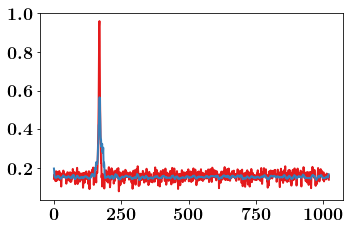

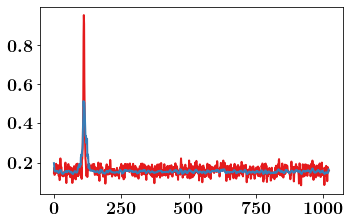

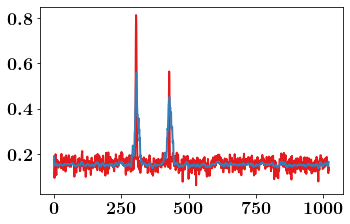

In [41]:
plt.plot(X[0,1:-1,0])
plt.plot(X_conv_ae[0,1:-2,0])
plt.show()


plt.plot(X[0,1:-1,1])
plt.plot(X_conv_ae[0,1:-2,1])
plt.show()


plt.plot(X[0,1:-1,2])
plt.plot(X_conv_ae[0,1:-2,2])
plt.show()


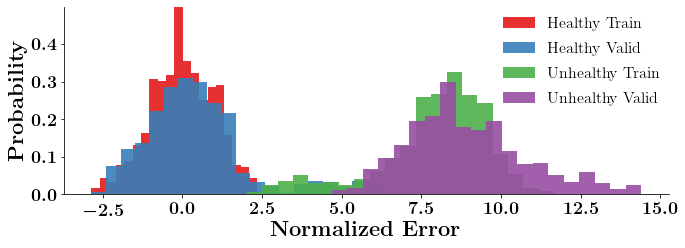

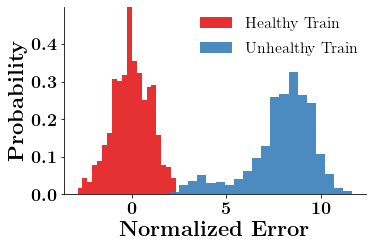

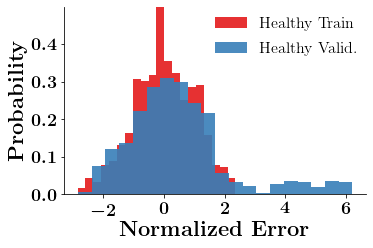

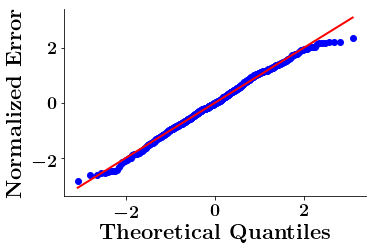

No handles with labels found to put in legend.


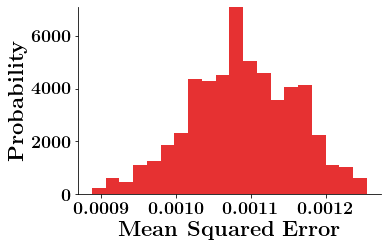

In [42]:
genplt.plot_histogram(norm_conv_ae,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE_NormalTest')

genplt.plot_histogram(mse_conv_ae[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE_Histogram_Train_Healthy',
               template='publication')

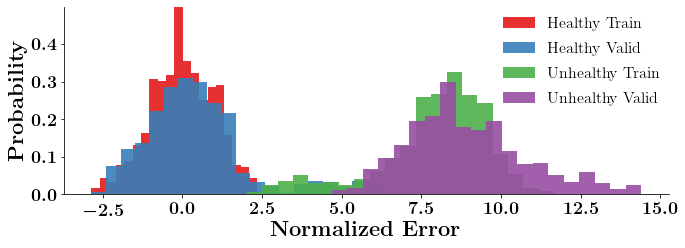

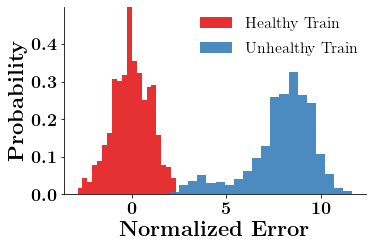

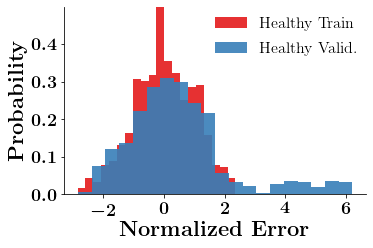

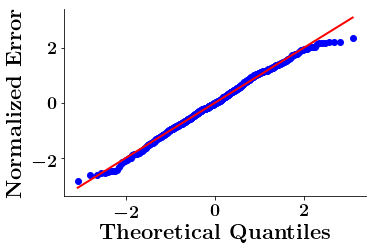

No handles with labels found to put in legend.


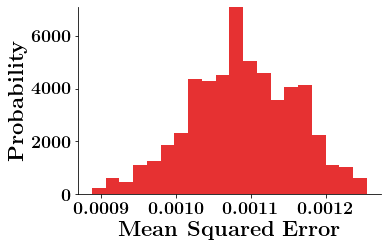

In [35]:
genplt.plot_histogram(norm_conv_ae_lite,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae_lite[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE-Lite_NormalTest')

genplt.plot_histogram(mse_conv_ae_lite[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE-Lite_Histogram_Train_Healthy',
               template='publication')

In [50]:
import tflite_runtime.interpreter as tflite

In [51]:
a = np.array([1,2,3,4,5,6])

In [52]:
a.shape

(6,)

In [54]:
np.atleast_2d(a).shape

(1, 6)